In [1]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [5]:
from json import load
import os
import pandas as pd
import numpy as np

In [9]:
cd '/projects/home-credit-default-risk/'

/projects/home-credit-default-risk


In [12]:
from src import utils, proj_utils

# Load training data

In [13]:
%%time
# Load dataframe.
df = proj_utils.load_data(train = True,
                     supp_dict = {'previous_application.csv.zip' : 'max',
                                  'credit_card_balance.csv.zip' : 'mean',
                                  'installments_payments.csv.zip' : 'min',
                                  'POS_CASH_balance.csv.zip' : 'mean',
                                  'bureau.csv.zip' : 'max'
                                 })

Loading training applications
Loading previous_application.csv.zip
Loading credit_card_balance.csv.zip
Loading installments_payments.csv.zip
Loading POS_CASH_balance.csv.zip
Loading bureau.csv.zip
CPU times: user 2min 13s, sys: 22.4 s, total: 2min 35s
Wall time: 1min 43s


In [55]:
%%time
# Load dataframe.
df_test = proj_utils.load_data(train = False,
                     supp_dict = {'previous_application.csv.zip' : 'max',
                                  'credit_card_balance.csv.zip' : 'mean',
                                  'installments_payments.csv.zip' : 'min',
                                  'POS_CASH_balance.csv.zip' : 'mean',
                                  'bureau.csv.zip' : 'max'
                                 })

Loading test applications
Loading previous_application.csv.zip
Loading credit_card_balance.csv.zip
Loading installments_payments.csv.zip
Loading POS_CASH_balance.csv.zip
Loading bureau.csv.zip
CPU times: user 2min 2s, sys: 17.9 s, total: 2min 20s
Wall time: 1min 32s


In [24]:
%%time
# Create design matrix
features = [x for x in df.columns if x != 'TARGET' and x != 'SK_ID_CURR']
X,y = utils.get_design_matrix_lbl(df, 'TARGET', features, convert_categorical = True)

/root/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 14.8 s, sys: 3.09 s, total: 17.9 s
Wall time: 5.9 s


In [57]:
X_test = utils.get_design_matrix_lbl(df_test, features = features, convert_categorical = True)

/root/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
kfold = StratifiedKFold(n_splits = 5, random_state = 123)

# Preprocess design matrix

In [26]:
from sklearn.preprocessing import FunctionTransformer

In [27]:
# Impute outliers
def clean_columns(data, m = 3):
    return np.apply_along_axis(null_outliers , 0, data, **{'m':m})

def null_outliers(x, m):
    z = (x - np.nanmean(x))/np.nanstd(x)
    outliers = abs(z) > m
    x[abs(z) > m] = np.nan
    return x

pipe_clean_columns = FunctionTransformer(func = clean_columns, validate= False)

# Build initial model

In [28]:
from lightgbm import LGBMClassifier

categorical_columns = list(df.columns[df.dtypes == object])
categorical_feature = 'name:' + ','.join(categorical_columns)

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'learning_rate': 0.0212,
          'reg_alpha': 0.8,
          'reg_lambda': 0.4,
          'subsample': 1,
          'feature_fraction': 0.3,
          'device_type': 'gpu',
          'metric' : 'auc',
          'random_state': 123,
          'n_estimators': 1313, 
          'num_leaves': 40, 
          'max_bin': 255,
          'min_data_in_leaf': 2400,
          'min_data_in_bin': 5}

clf = LGBMClassifier(**params)

In [29]:
model_1 = Pipeline([('outlier_detection', pipe_clean_columns),
                    ('clf', clf)])

In [31]:
score_1 = cross_val_score(model_1, X, y, scoring = 'roc_auc', cv = kfold)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: in

In [35]:
score_1.mean()

0.7872314772568456

In [32]:
model_1.fit(X, y)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Pipeline(memory=None,
     steps=[('outlier_detection', FunctionTransformer(accept_sparse=False,
          func=<function clean_columns at 0x7f46bbf90048>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('clf', LGBMClassifier(boosting_type='gbdt', class_weight=Non...0.8, reg_lambda=0.4, silent=True, subsample=1,
        subsample_for_bin=200000, subsample_freq=0))])

# Select features

In [39]:
model_1_importances = model_1.named_steps.clf.feature_importances_

In [44]:
model_1_importances.shape

(918,)

In [42]:
kept_features = X.columns[model_1_importances > 1]

In [46]:
kept_features.shape

(457,)

In [48]:
from mlxtend.feature_selection import ColumnSelector

In [49]:
model_2 = Pipeline([('keep_features', ColumnSelector(kept_features)),
                    ('outlier_detection', pipe_clean_columns),
                    ('clf', clf)])

In [50]:
score_2 = cross_val_score(model_2, X, y, scoring = 'roc_auc', cv = kfold)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: 

In [51]:
score_2.mean()

0.7874550308784579

In [52]:
model_2.fit(X,y)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Pipeline(memory=None,
     steps=[('keep_features', ColumnSelector(cols=Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'CREDIT_TYPE_Microloan_mean', 'CREDIT_TYP...0.8, reg_lambda=0.4, silent=True, subsample=1,
        subsample_for_bin=200000, subsample_freq=0))])

# Produce submission

In [58]:
y_hat = [x[1] for x in model_2.predict_proba(X_test)]

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [60]:
submission = pd.DataFrame({'SK_ID_CURR': df_test.SK_ID_CURR,
                           'TARGET': y_hat})

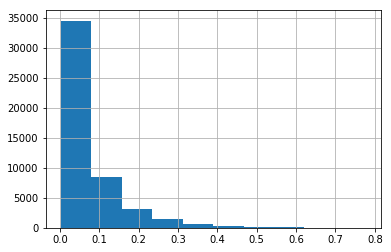

In [64]:
submission.TARGET.hist()

In [ ]:
submission.to_csv('submission_15.csv', index = False)